In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


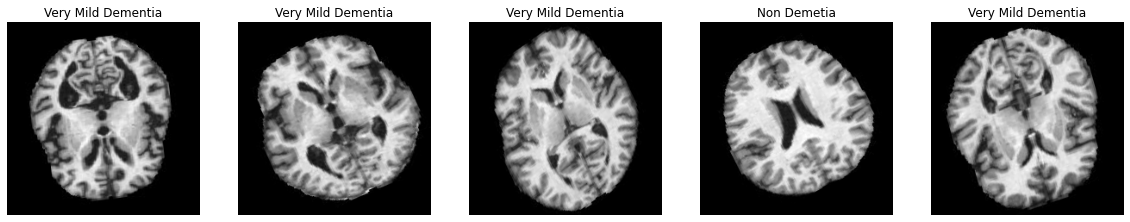

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [7]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51879936/51877672 [==============================] - 0s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 2048)              166987776 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.3478 - auc: 0.7884
Epoch 00001: val_auc improved from -inf to 0.74424, saving model to ./best_weights.hdf5
33/33 [==============================] - 79s 2s/step - loss: 1.3478 - auc: 0.7884 - val_loss: 3.6011 - val_auc: 0.7442
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.0949 - auc: 0.8307
Epoch 00002: val_auc did not improve from 0.74424
33/33 [==============================] - 62s 2s/step - loss: 1.0949 - auc: 0.8307 - val_loss: 3.3002 - val_auc: 0.6951
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.9985 - auc: 0.8483
Epoch 00003: val_auc did not improve from 0.74424
33/33 [==============================] - 61s 2s/step - loss: 0.9985 - auc: 0.8483 - val_loss: 1.9683 - val_auc: 0.7179
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 0.9680 - auc: 0.8561
Epoch 00004: val_auc improved from 0.74424 to 0.77494, saving model to ./best_weights.hdf5
33/3

Epoch 31/500
33/33 [==============================] - ETA: 0s - loss: 0.5382 - auc: 0.9472
Epoch 00031: val_auc did not improve from 0.85109
33/33 [==============================] - 63s 2s/step - loss: 0.5382 - auc: 0.9472 - val_loss: 1.1813 - val_auc: 0.8443
Epoch 32/500
33/33 [==============================] - ETA: 0s - loss: 0.5247 - auc: 0.9493
Epoch 00032: val_auc did not improve from 0.85109
33/33 [==============================] - 62s 2s/step - loss: 0.5247 - auc: 0.9493 - val_loss: 1.1229 - val_auc: 0.8433
Epoch 33/500
33/33 [==============================] - ETA: 0s - loss: 0.5209 - auc: 0.9508
Epoch 00033: val_auc improved from 0.85109 to 0.85514, saving model to ./best_weights.hdf5
33/33 [==============================] - 69s 2s/step - loss: 0.5209 - auc: 0.9508 - val_loss: 1.1118 - val_auc: 0.8551
Epoch 34/500
33/33 [==============================] - ETA: 0s - loss: 0.5035 - auc: 0.9534
Epoch 00034: val_auc did not improve from 0.85514
33/33 [==============================]

Epoch 62/500
33/33 [==============================] - ETA: 0s - loss: 0.4148 - auc: 0.9680
Epoch 00062: val_auc did not improve from 0.88778
33/33 [==============================] - 60s 2s/step - loss: 0.4148 - auc: 0.9680 - val_loss: 1.0889 - val_auc: 0.8713
Epoch 63/500
33/33 [==============================] - ETA: 0s - loss: 0.4253 - auc: 0.9662
Epoch 00063: val_auc did not improve from 0.88778
33/33 [==============================] - 61s 2s/step - loss: 0.4253 - auc: 0.9662 - val_loss: 1.0831 - val_auc: 0.8604
Epoch 64/500
33/33 [==============================] - ETA: 0s - loss: 0.4351 - auc: 0.9651
Epoch 00064: val_auc did not improve from 0.88778
33/33 [==============================] - 61s 2s/step - loss: 0.4351 - auc: 0.9651 - val_loss: 1.3710 - val_auc: 0.8447
Epoch 65/500
33/33 [==============================] - ETA: 0s - loss: 0.4204 - auc: 0.9673
Epoch 00065: val_auc did not improve from 0.88778
33/33 [==============================] - 61s 2s/step - loss: 0.4204 - auc: 0.96

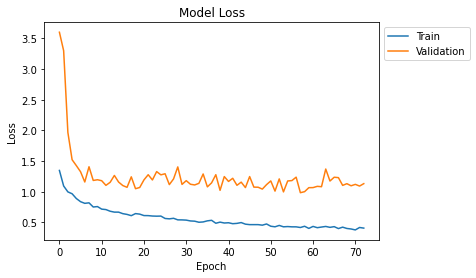

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

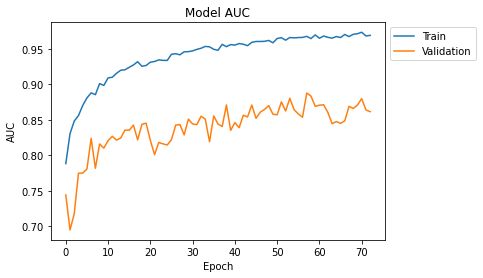

In [15]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [16]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)


Found 1279 images belonging to 4 classes.


In [17]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 5s 471ms/step - loss: 1.0594 - auc: 0.8897


[1.0594316720962524, 0.8896920680999756]

98.72 % chances are there that the image is NonDemented


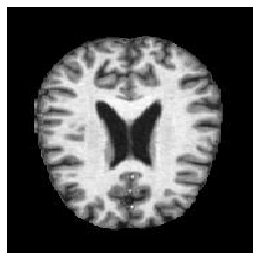

In [18]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

95.65 % chances are there that the image is MildDemented


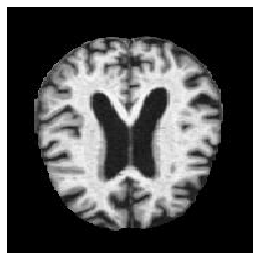

In [19]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

95.28 % chances are there that the image is ModerateDemented


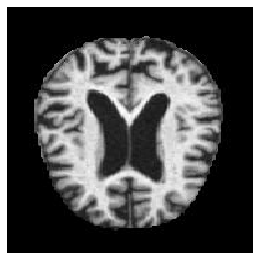

In [20]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])